In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [3]:
df= pd.read_csv('Data/NHANES_Diet_Diabetes_Risk.xls.csv')
df.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,...,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
0,73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
2,73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,...,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,NaN,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479,26.216,1.263,41.0,53.17,0.0,738.0,863.0,0.0,1476.0,0.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
4,73562,49890.82866,0.00000,1,49.0,2.0,1.0,11.0,3.0,1.0,1.0,13.0,1.0,3.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1785.0,55.11,189.59,81.75,22.6,93.92,22.155,40.013,23.550,534.0,12.30,0.0,272.0,355.0,172.0,776.0,300.0,2339.0,...,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0


In [4]:
df= df.set_index('SEQN')
df

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,...,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.890650,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.00,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.148870,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.00,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.236710,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.00,616.0,655.0,21.0,449.0,35.0,515.0,300.0,...,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73561,59052.35703,39004.892990,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,NaN,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479,26.216,1.263,41.0,53.17,0.00,738.0,863.0,0.0,1476.0,0.0,0.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
73562,49890.82866,0.000000,1,49.0,2.0,1.0,11.0,3.0,1.0,1.0,13.0,1.0,3.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1785.0,55.11,189.59,81.75,22.6,93.92,22.155,40.013,23.550,534.0,12.30,0.00,272.0,355.0,172.0,776.0,300.0,2339.0,2101.0,...,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83721,50162.97146,35482.349600,1,49.0,2.0,2.0,6.0,1.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1225.0,35.05,250.82,127.22,30.7,17.97,4.087,4.981,6.438,6.0,5.19,0.00,1072.0,1780.0,2619.0,7077.0,202.0,0.0,1909.0,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2

In [5]:
X = df.drop(columns =['Diabetes_Risk'])
y = df['Diabetes_Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
imputer = SimpleImputer(strategy='median')  
scaler = StandardScaler()  

# Preprocessing pipeline
preprocessor= make_pipeline(imputer, scaler)

preprocessor.fit(X_train)
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)
X_train_tf.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,...,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78382,-0.715608,-0.731159,-0.297916,-0.968771,0.0,-2.937143,-2.501602,0.720846,-0.258625,-0.072968,0.080588,0.049478,0.276526,0.663731,0.190694,-0.045459,0.148728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078889,-0.326293,-0.581458,-1.093459,-1.247807,-0.831982,-0.340368,0.075367,-0.335633,-0.671947,-0.380768,-0.396277,-0.183773,-0.141870,-0.408946,-0.291544,-0.434748,-0.156923,-0.568342,-0.165206,-0.173736,...,2.030380,0.173909,-0.085651,0.047574,-0.026951,0.0,-0.472882,0.267557,-0.138338,0.548504,-0.109187,0.121256,-0.062938,-3.010713,1.494163,0.278697,0.008617,0.193088,-0.044506,0.16389,-0.093003,0.113001,-0.052488,0.114697,0.011975,0.043421,-0.025933,0.140591,-0.071864,0.067356,0.0,0.530188,-0.112311,0.172178,-0.027385,0.114697,-0.058594,0.033621,-0.018408,0.096471,-0.035574,0.149386,-0.079852,0.056651,-0.032849,0.411023,-0.101666,0.205839,-0.028614,0.0
76088,0.477532,0.076250,-0.297916,0.248286,0.0,0.340467,-0.985452,1.199190,-0.258625,-0.072968,0.080588,-0.113678,-1.198835,-0.166753,0.190694,-0.045459,0.148728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078889,-0.417038,-0.778784,-0.618482,-1.083563,-0.706015,-0.567549,-0.837037,-0.310545,-0.281274,0.598087,-0.122009,-0.183773,-0.405288,-0.590507,-0.300338,-0.420748,-0.183527,-0.336001,-0.268202,-1.173098,...,-0.802795,-5.750139,-0.085651,0.047574,-0.026951,0.0,-0.472882,0.267557,-0.138338,0.548504,-0.109187,0.121256,-0.062938,0.332147,-0.174251,0.278697,0.008617,0.193088,-0.044506,0.16389,-0.093003,0.113001,-0.052488,0.114697,0.011975,0.043421,-0.025933,0.140591,-0.071864,0.067356,0.0,-1.886123,1.602698,0.172178,-0.027385,0.114697,-0.058594,0.033621,-0.018408,0.096471,-0.035574,0.149386,-0.079852,0.056651,-0.032849,-2.432955,-1.005101,0.205839,-0.028614,0.0
83084,-0.321466,-0.367972,-0.297916,0.248286,0.0,0.340467,-0.896267,-1.670872,1.561683,-0.072968,0.080588,-0.195256,-1.198835,-0.166753,-1.197454,-0.045459,0.148728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078889,-0.769820,-1.072040,-0.180128,0.590561,-0.880431,-1.360187,-1.353599,-1.332111,-1.045040,-1.006028,-0.776131,-0.183773,-0.588647,-0.615674,-0.242302,-0.278096,-0.002618,-0.431943,-0.103694,-0.865432,...,-0.094501,0.173909,-0.085651,0.047574,-0.026951,0.0,-0.472882,0.267557,-0.138338,-1.823140,-0.109187,0.121256,-0.062938,0.332147,-0.174251,0.278697,0.008617,0.193088,-0.044506,0.16389,-0.093003,0.113001,-0.052488,0.114697,0.011975,0.043421,-0.025933,0.140591,-0.071864,0.067356,0.0,-1.886123,-0.112311,0.172178,-0.027385,0.114697,-0.058594,0.033621,-0.018408,0.096471,-0.035574,0.149386,-0.079852,0.056651,-0.032849,-2.432955,0.801769,0.205839,-0.028614,0.0
75571,-0.796295,-0.632738,-0.297916,-0.968771,0.0,0.340467,-0.896267,1.199190,-0.258625,-0.072968,0.080588,0.049478,0.276526,0.663731,0.190694,-0.045459,0.148728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.089055,-0.113197,0.709596,-0.358477,-0.049913,-0.279667,-0.507879,-0.944651,-0.541401,0.022435,-0.027173,-0.304854,-0.183773,-0.570569,-0.241767,0.163951,0.250270,-0.148942,-0.428218,1.022401,-0.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# Record the time it takes to make predictions
knn = KNeighborsClassifier(n_neighbors=5)

# %%time
knn_model = knn.fit(X_train_tf, y_train)
preds= knn.predict(X_test_tf)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      4364
           1       0.57      0.05      0.10       461
           2       0.69      0.04      0.08       489

    accuracy                           0.83      5314
   macro avg       0.70      0.36      0.36      5314
weighted avg       0.79      0.83      0.76      5314



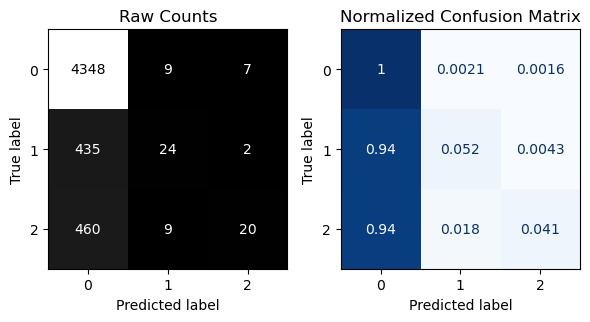


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1088
           1       0.29      0.03      0.06       126
           2       0.31      0.03      0.06       115

    accuracy                           0.81      1329
   macro avg       0.47      0.35      0.34      1329
weighted avg       0.73      0.81      0.75      1329



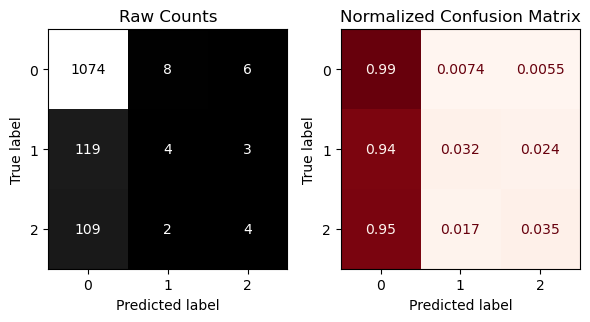

Training time was: 0:00:00.000013


In [9]:
import datetime as dt

# Record the start time
start = dt.datetime.now()

end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(knn_model, X_train_tf,y_train, X_test_tf, y_test)
print(f'Training time was: {dur_baseline}')

In [10]:
## PCA 

# Instantiate & fit data using PCA
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train_tf)
X_test_pca = pca.transform(X_test_tf)
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60,pca61,pca62,pca63,pca64,pca65,pca66,pca67,pca68,pca69,pca70,pca71,pca72,pca73,pca74,pca75,pca76,pca77,pca78,pca79,pca80,pca81,pca82,pca83,pca84,pca85,pca86,pca87,pca88,pca89,pca90,pca91,pca92,pca93,pca94,pca95,pca96,pca97,pca98
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78382,-1.293985,1.288009,-2.041216,-3.672101,2.511382,3.451035,-2.503447,1.408218,-1.241948,-1.915718,5.286115,-0.058615,1.906373,0.943577,3.041708,1.024066,2.781707,1.551882,-8.901566,-0.728745,-3.778402,-0.895404,-2.791218,-6.895155,0.451622,2.842210,-2.509731,3.564282,0.174860,-0.055080,-1.814536,-6.975696,-1.897320,-4.984940,10.410792,-6.710320,2.317831,-1.697606,0.488805,1.858311,-7.212714,-1.733905,1.804124,-1.711209,-0.438006,1.399496,-2.266831,0.591457,-1.080501,-0.714877,-2.978656,-1.866432,-1.273092,0.118037,-2.234500,-0.212627,-2.900685,-1.276552,-1.082194,-0.318424,-1.023328,1.100661,1.166946,-2.557891,0.300201,-0.238363,-1.073851,2.918204,-1.581869,0.786318,4.482756,1.992284,-0.064208,0.250404,2.006067,0.564251,2.706429,2.092715,-3.010154,1.514291,-3.758788,1.046474,-0.487584,2.631203,-4.004969,-6.459756,-0.660903,-7.565735,1.406643,-2.114475,-2.171520,-1.479011,1.769677,1.924541,0.156016,1.773149,1.234418,0.861734,0.415035
76088,-2.767285,5.557670,-3.058550,-2.545894,1.243589,3.529681,-2.638267,-1.300188,0.180236,-0.911780,-2.040327,-2.248390,-0.806756,-1.864487,1.417588,0.445108,0.557817,-0.283175,-1.235474,0.514133,0.847836,-1.273438,-1.115974,2.419426,0.840677,-0.137075,-1.230370,-1.263109,-1.017482,1.045338,0.535194,0.060723,-0.116753,0.895898,-2.454111,1.705302,-0.448614,0.028721,-0.812196,0.456307,0.938014,-0.303399,-1.540343,-0.187417,1.814075,0.662870,-0.373452,-1.178102,0.577408,1.839825,-0.618080,-1.029164,-2.165013,0.435154,0.482567,1.073908,-0.047271,-1.135066,-1.350794,0.446332,0.872506,-0.280696,0.472495,-0.799133,-1.077852,0.117723,-1.560215,1.447183,-0.740843,-1.957228,-0.276954,0.849575,1.771067,0.707312,-0.654746,0.411564,1.052681,0.682001,0.434583,0.368436,-0.267182,0.896049,0.405435,0.014244,-1.192594,1.348116,0.338487,-0.707411,-1.205695,-1.887908,0.374566,-1.898709,1.674515,1.116844,0.109566,-0.401999,-1.557885,0.570745,-1.420016
83084,-5.206469,3.105846,-0.487084,-0.068170,0.302799,-1.816099,0.961043,-0.116588,0.426766,-0.923930,-0.445544,0.483628,-0.385699,0.390181,0.854524,-0.761709,-0.791734,0.014552,-0.222354,0.342839,-0.561300,0.392754,0.323009,-0.296021,-0.220596,-0.454893,-0.064208,-1.782087,-0.990479,0.128553,0.014766,1.035581,0.228714,0.062527,-0.024284,-1.309544,-0.142546,-0.242172,0.608745,-0.092655,0.386081,-0.358526,-0.223535,-0.079804,0.164991,0.661584,-1.627898,0.844971,-0.098238,-0.114212,0.604394,0.143340,-0.711426,0.404330,-0.535814,0.316312,0.460708,-0.733508,0.402951,-0.004528,-0.496464,-0.924297,-0.330279,-0.369725,0.785882,-0.057375,0.211634,0.335294,1.839243,-0.483899,0.298310,0.077107,0.369090,0.043684,0.310730,-0.276620,0.255751,0.018399,0.767925,-0.074672,-0.519783,0.131072,-1.385100,-0.233858,-0.102513,-0.261516,0.245486,0.566659,-0.194550,-0.077499,0.413914,0.181025,-0.289398,0.227765,0.023666,0.093614,-0.047996,-0.343261,0.009706
75571,1.001179,8.032367,-5.098287,2.986368,3.704052,-1.901122,1.810539,-0.084201,0.376918,-0.912871,-0.124667,4.932241,3.756837,2.154181,-0.990449,1.427566,-3.642986,2.977818,0.397137,3.231295,-0.045431,-2.595460,-1.548851,-0.380025,0.353114,-0.256723,-3.578729,-0.051303,0.938029,2.213318,-0.542482,-0.334440,1.687863,-0.337804,-3.222862,2.182510,-1.306995,-1.834325,0.086889,-1.647929,0.306361,1.848749,0.662812,-0.194634,0.262301,-1.073808,0.265474,0.702168,-1.3

In [11]:
# Record the time it takes to make predictions with PCA data
knn_pca = knn.fit(X_train_pca, y_train)
preds= knn.predict(X_test_pca)

#%%time
preds_pca = knn_pca.predict(X_test_pca)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4364
           1       0.60      0.06      0.11       461
           2       0.71      0.04      0.08       489

    accuracy                           0.83      5314
   macro avg       0.71      0.37      0.36      5314
weighted avg       0.80      0.83      0.76      5314



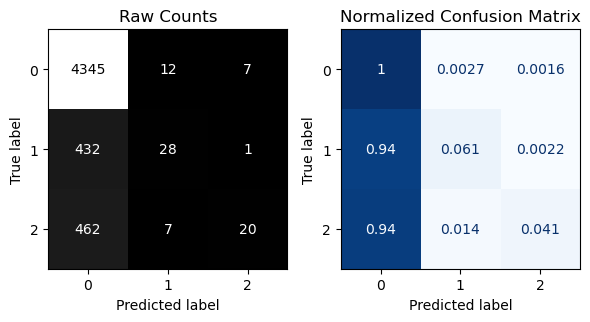


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1088
           1       0.27      0.03      0.06       126
           2       0.10      0.01      0.02       115

    accuracy                           0.81      1329
   macro avg       0.40      0.34      0.32      1329
weighted avg       0.71      0.81      0.74      1329



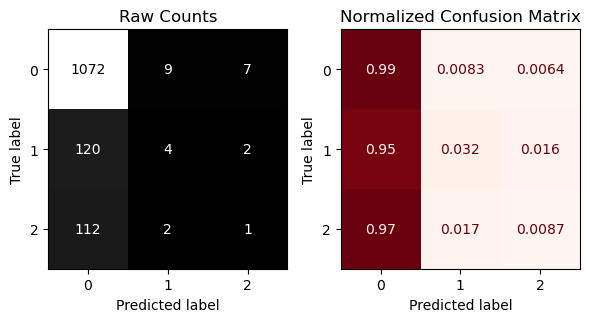

Training time was: 0:00:00.000018


In [12]:
start = dt.datetime.now()

end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(knn_pca, X_train_pca,y_train, X_test_pca, y_test)
print(f'Training time was: {dur_baseline}')

Q1. How many features were used in the first model, and how many PCs were used in the PCA model? 
The first model had 166 columns and the pca model has 96 columns

Q2. Which model performed the best on the test set?
The first model performed better

Q3. Which model was the fastest at making predictions?
The first model was faster.